# parPE example: steadystate model - minibatch optimization

This example demonstrates some basic use of the mini-batch optimizer in parPE.

## Prerequisites

The prerequisites mention in `parpeExampleSteadystateBasic.ipynb` also apply to this notebook.

In [1]:
import amici
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py
from importlib import reload

# set paths
parpe_source_root = os.path.abspath('../../../')
parpe_build_root = os.path.join(parpe_source_root, 'build') 

model_source_dir = f'{parpe_build_root}/examples/parpeamici/steadystate/steadystate_scaled-prefix/src/steadystate_scaled/model_steadystate_scaled'
example_binary_dir = f'{parpe_build_root}/examples/parpeamici/steadystate/'
example_data_dir = f'{parpe_build_root}/examples/parpeamici/steadystate/steadystate_scaled-prefix/src/steadystate_scaled'
optimizationOptionsPy = f'{parpe_source_root}/misc/optimizationOptions.py'

# load parpe module from source tree
sys.path.insert(0, os.path.join(parpe_source_root, 'python'))
import parpe

In [2]:
# rebuild example
!cd {parpe_build_root} && make

[  9%] Built target parpecommon
[ 20%] Built target parpeoptimization
[ 23%] Built target parpeloadbalancer
[ 35%] Built target parpeamici
[ 36%] Built target parpe
-- Found Git: /usr/bin/git (found version "2.20.1") 
-- Building version parPE-v0.3.1-19-g9551-dirty
[ 36%] Built target get_version
[ 42%] Built target unittests_common
[ 47%] Built target unittests_loadbalancer
[ 54%] Built target unittests_optimization
Setting up virtual environment...
[ 54%] Built target setup_venv
[ 55%] Creating test data using hierarchicalOptimizationTest.py
...
----------------------------------------------------------------------
Ran 3 tests in 0.000s

OK
[ 55%] Built target prepare_test_hierarchical_optimization
[ 63%] Built target unittests_amici
[ 65%] Built target example_loadbalancer
[ 76%] Built target steadystate_scaled
[ 79%] Built target example_steadystate_multi_simulator
[ 85%] Built target example_steadystate_parallel
[ 89%] Built target example_steadystate_multi
[ 92%] Built target exa

In [3]:
# run make test to generated all output files required below
# !cd {parpe_build_root} && make test

## Mini-batch optimization

In [4]:
hdf5FileMinibatch = f'{example_data_dir}/example_data_minibatch.h5'
!cp {example_data_dir}/example_data.h5 {hdf5FileMinibatch}

# Generic options:
# One optimizer run 
!{optimizationOptionsPy} {hdf5FileMinibatch} -s numStarts 1
# Hierarchical optimization not yet supported with minibatch (#118)
!{optimizationOptionsPy} {hdf5FileMinibatch} -s hierarchicalOptimization 0
# Do not repeat on failure
!{optimizationOptionsPy} {hdf5FileMinibatch} -s retryOptimization 0

# Mini-batch options:
# Select mini-batch optimizer
!{optimizationOptionsPy} {hdf5FileMinibatch} -s optimizer 10
# Set number of epochs
!{optimizationOptionsPy} {hdf5FileMinibatch} -s minibatch/maxEpochs 40
# Set batch-size
!{optimizationOptionsPy} {hdf5FileMinibatch} -s minibatch/batchSize 2
# Set parameter updating scheme
!{optimizationOptionsPy} {hdf5FileMinibatch} -s minibatch/parameterUpdater Vanilla
# Set learning rate
!{optimizationOptionsPy} {hdf5FileMinibatch} -s minibatch/startLearningRate 1e-5
!{optimizationOptionsPy} {hdf5FileMinibatch} -s minibatch/endLearningRate 1e-5

# Print settings
!{optimizationOptionsPy} {hdf5FileMinibatch}

                hierarchicalOptimization            0
                               numStarts            1
                               optimizer           10
                       retryOptimization            0
                ceres/max_num_iterations          100
                         fmincon/GradObj        b'on'
                     fmincon/MaxFunEvals   10000000.0
                         fmincon/MaxIter          100
                          fmincon/TolFun            0
                            fmincon/TolX        1e-08
                       fmincon/algorithm b'interior-point'
                         fmincon/display      b'iter'
                   ipopt/acceptable_iter            1
         ipopt/acceptable_obj_change_tol        1e-05
                    ipopt/acceptable_tol        1e-05
             ipopt/hessian_approximation b'limited-memory'
        ipopt/limited_memory_update_type      b'bfgs'
                          ipopt/max_iter           20
                  

In [5]:
# Optional
!{parpe_source_root}/misc/selectStartingPoints.py {hdf5FileMinibatch} 9 # select starting point

Creating starting point backup in /optimizationOptions/randomStartsBackup
Selecting starting points [9]


In [6]:
!PARPE_MAX_SIMULATIONS_PER_PACKAGE=1 PARPE_NO_DEBUG=1 mpiexec -np 4 {example_binary_dir}/example_steadystate_multi -o deleteme-minibatch/ {hdf5FileMinibatch}

[2019-06-05 20:20:25] [INF] [0/dweindl-ThinkPad-L480] Running with 4 MPI processes.
[2019-06-05 20:20:25] [INF] [0/dweindl-ThinkPad-L480] Reading random initial theta 0 from /optimizationOptions/randomStarts
[2019-06-05 20:20:25] [INF] [0/dweindl-ThinkPad-L480] [o0e0b1] iter: 0 cost: 440754 time_iter: wall: 0.172925s cpu: 0.323503s time_optim: wall: 0.172925s cpu: 0.323503s
[2019-06-05 20:20:25] [INF] [0/dweindl-ThinkPad-L480] [o0e1b1] iter: 1 cost: 455293 time_iter: wall: 0.176629s cpu: 0.324911s time_optim: wall: 0.349555s cpu: 0.648414s
[2019-06-05 20:20:25] [INF] [0/dweindl-ThinkPad-L480] [o0e2b1] iter: 2 cost: 440192 time_iter: wall: 0.168691s cpu: 0.312289s time_optim: wall: 0.518246s cpu: 0.960703s
[2019-06-05 20:20:26] [INF] [0/dweindl-ThinkPad-L480] [o0e3b1] iter: 3 cost: 430821 time_iter: wall: 0.153559s cpu: 0.292556s time_optim: wall: 0.671805s cpu: 1.25326s
[2019-06-05 20:20:26] [INF] [0/dweindl-ThinkPad-L480] [o0e4b1] iter: 4 cost: 440113 time_iter: wall: 0.152302s cpu: 0

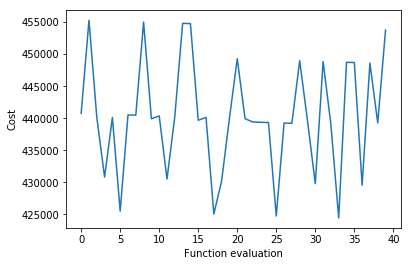

In [7]:
filename = 'deleteme-minibatch/_rank00000.h5'
with h5py.File(filename, 'r') as f:
    trajectory = f['/multistarts/0/iterCostFunCost'][:]
for start in range(trajectory.shape[0]):
    plt.plot(trajectory[start])
    plt.gca().set_xlabel("Function evaluation")
    plt.gca().set_ylabel("Cost")
#trajectory

### Compare learning rates

In [8]:
learningRates = np.logspace(-2, -5, 4)
for i, learningRate in enumerate(learningRates):
    curInputFile = "example-data-minibatch-rate-%d.h5" % i
    outprefix = "deleteme-minibatch-rate-%d/" % i
    !cp {hdf5FileMinibatch} {curInputFile}
    !{optimizationOptionsPy} {curInputFile} -s minibatch/startLearningRate learningRate
    !{optimizationOptionsPy} {curInputFile} -s minibatch/endLearningRate 1e-5
    !PARPE_MAX_SIMULATIONS_PER_PACKAGE=1 PARPE_NO_DEBUG=1 mpiexec -np 4 {example_binary_dir}/example_steadystate_multi -o {outprefix} {hdf5FileMinibatch}

[2019-06-05 20:20:35] [INF] [0/dweindl-ThinkPad-L480] Running with 4 MPI processes.
[2019-06-05 20:20:35] [INF] [0/dweindl-ThinkPad-L480] Reading random initial theta 0 from /optimizationOptions/randomStarts
[2019-06-05 20:20:35] [INF] [0/dweindl-ThinkPad-L480] [o0e0b1] iter: 0 cost: 455334 time_iter: wall: 0.196381s cpu: 0.35513s time_optim: wall: 0.196382s cpu: 0.35513s
[2019-06-05 20:20:35] [INF] [0/dweindl-ThinkPad-L480] [o0e1b1] iter: 1 cost: 440231 time_iter: wall: 0.198754s cpu: 0.365421s time_optim: wall: 0.395136s cpu: 0.720551s
[2019-06-05 20:20:35] [INF] [0/dweindl-ThinkPad-L480] [o0e2b1] iter: 2 cost: 430860 time_iter: wall: 0.199417s cpu: 0.370409s time_optim: wall: 0.594553s cpu: 1.09096s
[2019-06-05 20:20:35] [INF] [0/dweindl-ThinkPad-L480] [o0e3b1] iter: 3 cost: 449968 time_iter: wall: 0.174213s cpu: 0.334633s time_optim: wall: 0.768766s cpu: 1.42559s
[2019-06-05 20:20:36] [INF] [0/dweindl-ThinkPad-L480] [o0e4b1] iter: 4 cost: 425539 time_iter: wall: 0.166797s cpu: 0.32

[2019-06-05 20:20:46] [INF] [0/dweindl-ThinkPad-L480] [o0e2b1] iter: 2 cost: 455253 time_iter: wall: 0.15743s cpu: 0.300118s time_optim: wall: 0.553872s cpu: 1.03983s
[2019-06-05 20:20:46] [INF] [0/dweindl-ThinkPad-L480] [o0e3b1] iter: 3 cost: 425577 time_iter: wall: 0.156741s cpu: 0.30122s time_optim: wall: 0.710614s cpu: 1.34105s
[2019-06-05 20:20:46] [INF] [0/dweindl-ThinkPad-L480] [o0e4b1] iter: 4 cost: 430783 time_iter: wall: 0.154697s cpu: 0.29863s time_optim: wall: 0.865312s cpu: 1.63968s
[2019-06-05 20:20:46] [INF] [0/dweindl-ThinkPad-L480] [o0e5b1] iter: 5 cost: 425501 time_iter: wall: 0.158478s cpu: 0.303047s time_optim: wall: 1.02379s cpu: 1.94273s
[2019-06-05 20:20:46] [INF] [0/dweindl-ThinkPad-L480] [o0e6b1] iter: 6 cost: 455091 time_iter: wall: 0.16453s cpu: 0.310415s time_optim: wall: 1.18832s cpu: 2.25315s
[2019-06-05 20:20:46] [INF] [0/dweindl-ThinkPad-L480] [o0e7b1] iter: 7 cost: 440480 time_iter: wall: 0.161794s cpu: 0.310021s time_optim: wall: 1.35011s cpu: 2.56317s

[2019-06-05 20:20:56] [INF] [0/dweindl-ThinkPad-L480] [o0e5b1] iter: 5 cost: 425501 time_iter: wall: 0.167821s cpu: 0.323537s time_optim: wall: 1.02621s cpu: 1.9784s
[2019-06-05 20:20:56] [INF] [0/dweindl-ThinkPad-L480] [o0e6b1] iter: 6 cost: 425463 time_iter: wall: 0.169986s cpu: 0.326242s time_optim: wall: 1.1962s cpu: 2.30464s
[2019-06-05 20:20:56] [INF] [0/dweindl-ThinkPad-L480] [o0e7b1] iter: 7 cost: 439996 time_iter: wall: 0.165399s cpu: 0.319428s time_optim: wall: 1.3616s cpu: 2.62407s
[2019-06-05 20:20:56] [INF] [0/dweindl-ThinkPad-L480] [o0e8b1] iter: 8 cost: 439957 time_iter: wall: 0.166337s cpu: 0.320366s time_optim: wall: 1.52793s cpu: 2.94443s
[2019-06-05 20:20:56] [INF] [0/dweindl-ThinkPad-L480] [o0e9b1] iter: 9 cost: 449728 time_iter: wall: 0.169976s cpu: 0.328398s time_optim: wall: 1.69791s cpu: 3.27283s
[2019-06-05 20:20:56] [INF] [0/dweindl-ThinkPad-L480] [o0e10b1] iter: 10 cost: 425312 time_iter: wall: 0.164675s cpu: 0.31668s time_optim: wall: 1.86258s cpu: 3.58951s


[2019-06-05 20:21:07] [INF] [0/dweindl-ThinkPad-L480] [o0e8b1] iter: 8 cost: 440441 time_iter: wall: 0.1703s cpu: 0.330921s time_optim: wall: 1.57545s cpu: 3.04018s
[2019-06-05 20:21:07] [INF] [0/dweindl-ThinkPad-L480] [o0e9b1] iter: 9 cost: 430591 time_iter: wall: 0.170494s cpu: 0.328734s time_optim: wall: 1.74595s cpu: 3.36891s
[2019-06-05 20:21:07] [INF] [0/dweindl-ThinkPad-L480] [o0e10b1] iter: 10 cost: 439878 time_iter: wall: 0.180963s cpu: 0.342055s time_optim: wall: 1.92691s cpu: 3.71097s
[2019-06-05 20:21:07] [INF] [0/dweindl-ThinkPad-L480] [o0e11b1] iter: 11 cost: 440323 time_iter: wall: 0.167945s cpu: 0.324897s time_optim: wall: 2.09485s cpu: 4.03587s
[2019-06-05 20:21:07] [INF] [0/dweindl-ThinkPad-L480] [o0e12b1] iter: 12 cost: 454848 time_iter: wall: 0.166169s cpu: 0.321957s time_optim: wall: 2.26102s cpu: 4.35782s
[2019-06-05 20:21:07] [INF] [0/dweindl-ThinkPad-L480] [o0e13b1] iter: 13 cost: 430437 time_iter: wall: 0.169159s cpu: 0.324902s time_optim: wall: 2.43018s cpu: 4

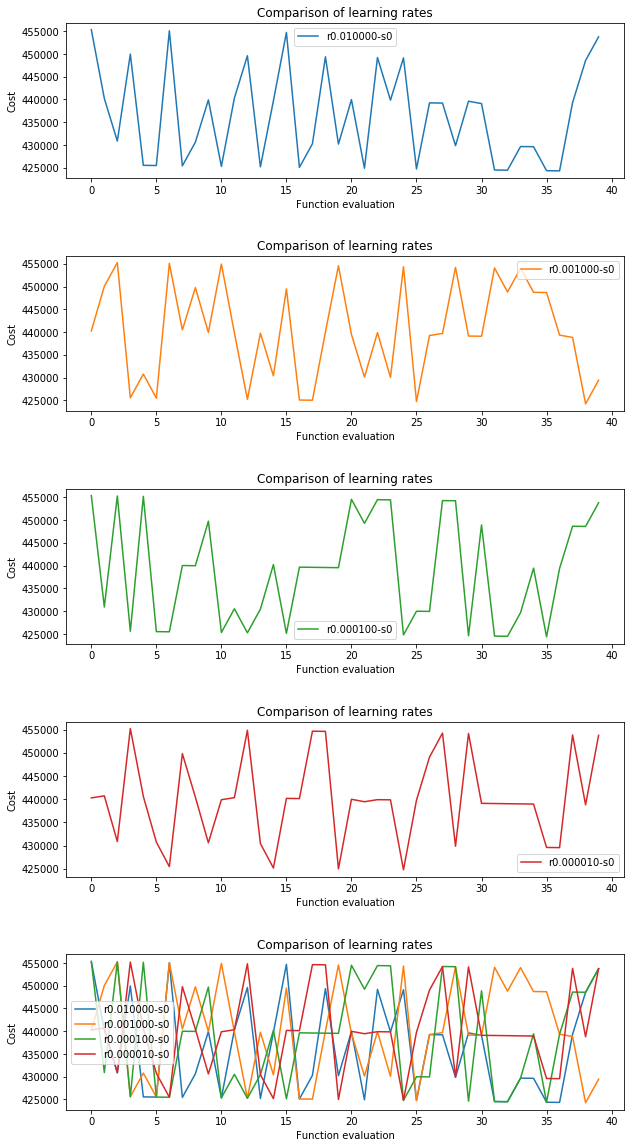

In [9]:
fig, axs = plt.subplots(nrows=len(learningRates) + 1, figsize=(10, 20))
for i, learningRate in enumerate(learningRates):
    filename = "deleteme-minibatch-rate-%d/_rank00000.h5" % i
    with h5py.File(filename, 'r') as f:
        trajectory = f['/multistarts/0/iterCostFunCost'][:]
    for start in range(trajectory.shape[0]):
        # Individual plot + overlay
        for ax in (axs[i], axs[-1]):
            ax.plot(trajectory[start], label="r%f-s%d"%(learningRate, start), color="C%d"%i)
            ax.set_xlabel("Function evaluation")
            ax.set_ylabel("Cost")
            ax.set_title("Comparison of learning rates")
            ax.legend()
plt.subplots_adjust(hspace=0.5)